# Version 1 : L'idée générale du _behemoth_

In [ ]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import roc_auc_score, average_precision_score
import xgboost as xgb

# ---------- 0) DATASET TUILE PAR TUILE ----------
data_dir   = Path("C:/Users/flobm/PRAMA_2025")
features_d = data_dir / "train_input/train_input/moco_features"
labels_p   = data_dir / "train_output.csv"

labels_df = pd.read_csv(labels_p).set_index("Sample ID")

X_lst, y_lst, g_lst = [], [], []

for sid, target in labels_df["Target"].items():
    path = features_d / f"{sid}"
    if not path.exists():
        print(f"Missing {path}")
        continue
    mat = np.load(path)[:, 3:]               # (n_tiles, 2048)
    n = mat.shape[0]

    X_lst.append(mat)
    y_lst.append(np.full(n, target))
    g_lst.append(np.repeat(str(sid), n))     # ← FIX : pas de troncature

X       = np.vstack(X_lst)
y       = np.concatenate(y_lst)
groups  = np.concatenate(g_lst)              # (N_tiles,)



# ---------- 1) TRAIN / VAL SPLIT ----------
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, val_idx = next(gss.split(X, y, groups))

X_tr, y_tr = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]


# ---------- 2) STAGE-1 ----------
base = xgb.XGBClassifier(
    n_estimators=250,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.7,
    colsample_bytree=0.7,
    eval_metric="logloss",
    use_label_encoder=False,
    n_jobs=5,
    random_state=42,
)
base.fit(X_tr, y_tr)

proba_all = base.predict_proba(X)[:, 1]

# ---------- 3) SELECTION TOP-k ----------
k = 100
print(f"début de la sélection des {k} tuiles les plus expressives")

sel_mask = np.zeros_like(y, dtype=bool)

for sid in labels_df.index:                  # sid en chaîne complète
    idx = np.where(groups == str(sid))[0]
    if len(idx) == 0:                        # si path manquant
        continue
    label = y[idx[0]]
    scores = proba_all[idx] if label == 1 else (1 - proba_all[idx])
    top_idx = idx[np.argsort(-scores)[:min(k, len(idx))]]
    sel_mask[top_idx] = True

X_sel, y_sel = X[sel_mask], y[sel_mask]
groups_sel   = groups[sel_mask]

print(f"sélection des {k} meilleures tuiles effectuée")

# Re-utilise la même séparation groupe-wise
train_sel = sel_mask & np.isin(np.arange(len(y)), train_idx)
val_sel   = sel_mask & np.isin(np.arange(len(y)), val_idx)

X_tr2, y_tr2 = X[train_sel], y[train_sel]
X_val2, y_val2 = X[val_sel], y[val_sel]


# ---------- 4) STAGE-2 ----------
final = xgb.XGBClassifier(
    n_estimators=90,
    max_depth=1,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(y_tr2 == 0).sum() / (y_tr2 == 1).sum(),
    eval_metric="auc",
    use_label_encoder=False,
    n_jobs=5,
    random_state=42,
)
final.fit(X_tr2, y_tr2,
          eval_set=[(X_val2, y_val2)],
          verbose=True)

# ---------- 5) METRICS ----------
proba_val = final.predict_proba(X_val2)[:, 1]
auc  = roc_auc_score(y_val2, proba_val)
aupr = average_precision_score(y_val2, proba_val)

print(f"Tiles retained  : {X_sel.shape[0]:,} / {X.shape[0]:,}")
print(f"AUC  ROC        : {auc:.4f}")
print(f"Average Precision: {aupr:.4f}")



version avec courbe auc

In [2]:
import numpy as np
import pandas as pd
import os
from pathlib import Path
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve   # + roc_curve
import xgboost as xgb
import matplotlib.pyplot as plt                                                # + matplotlib

# ---------- 0) DATASET TUILE PAR TUILE ----------
data_dir   = Path("C:/Users/flobm/PRAMA_2025")
features_d = data_dir / "train_input/train_input/moco_features"
labels_p   = data_dir / "train_output.csv"

labels_df = pd.read_csv(labels_p).set_index("Sample ID")

X_lst, y_lst, g_lst = [], [], []

for sid, target in labels_df["Target"].items():
    path = features_d / f"{sid}"
    if not path.exists():
        print(f"Missing {path}")
        continue
    mat = np.load(path)[:, 3:]               # (n_tiles, 2048)
    n = mat.shape[0]

    X_lst.append(mat)
    y_lst.append(np.full(n, target))
    g_lst.append(np.repeat(str(sid), n))     # pas de troncature

X       = np.vstack(X_lst)
y       = np.concatenate(y_lst)
groups  = np.concatenate(g_lst)

# ---------- 1) TRAIN / VAL SPLIT ----------
gss = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
train_idx, val_idx = next(gss.split(X, y, groups))

X_tr, y_tr = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]

# ---------- 2) STAGE-1 ----------
base = xgb.XGBClassifier(
    n_estimators=250,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.7,
    colsample_bytree=0.7,
    eval_metric="logloss",
    use_label_encoder=False,
    n_jobs=5,
    random_state=42,
)
base.fit(X_tr, y_tr)
proba_all = base.predict_proba(X)[:, 1]

# ---------- 3) SELECTION TOP-k ----------
k = 100
sel_mask = np.zeros_like(y, dtype=bool)

for sid in labels_df.index:
    idx = np.where(groups == str(sid))[0]
    if len(idx) == 0:
        continue
    label   = y[idx[0]]
    scores  = proba_all[idx] if label == 1 else (1 - proba_all[idx])
    top_idx = idx[np.argsort(-scores)[:min(k, len(idx))]]
    sel_mask[top_idx] = True

X_sel, y_sel   = X[sel_mask], y[sel_mask]
train_sel      = sel_mask & np.isin(np.arange(len(y)), train_idx)
val_sel        = sel_mask & np.isin(np.arange(len(y)), val_idx)
X_tr2, y_tr2   = X[train_sel], y[train_sel]
X_val2, y_val2 = X[val_sel],  y[val_sel]

# ---------- 4) STAGE-2 ----------
final = xgb.XGBClassifier(
    n_estimators=90,
    max_depth=1,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=(y_tr2 == 0).sum() / (y_tr2 == 1).sum(),
    eval_metric="auc",
    use_label_encoder=False,
    n_jobs=5,
    random_state=42,
)
final.fit(X_tr2, y_tr2, eval_set=[(X_val2, y_val2)], verbose=True)


c:\Users\flobm\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:56:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[0]	validation_0-auc:0.68937


c:\Users\flobm\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:02:17] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[1]	validation_0-auc:0.69164
[2]	validation_0-auc:0.69237
[3]	validation_0-auc:0.69237
[4]	validation_0-auc:0.69237
[5]	validation_0-auc:0.79077
[6]	validation_0-auc:0.79077
[7]	validation_0-auc:0.79337
[8]	validation_0-auc:0.79337
[9]	validation_0-auc:0.79337
[10]	validation_0-auc:0.79337
[11]	validation_0-auc:0.79419
[12]	validation_0-auc:0.79480
[13]	validation_0-auc:0.79893
[14]	validation_0-auc:0.79903
[15]	validation_0-auc:0.79890
[16]	validation_0-auc:0.79915
[17]	validation_0-auc:0.79915
[18]	validation_0-auc:0.79915
[19]	validation_0-auc:0.79922
[20]	validation_0-auc:0.79953
[21]	validation_0-auc:0.80011
[22]	validation_0-auc:0.80068
[23]	validation_0-auc:0.80062
[24]	validation_0-auc:0.80079
[25]	validation_0-auc:0.80079
[26]	validation_0-auc:0.80079
[27]	validation_0-auc:0.80103
[28]	validation_0-auc:0.80186
[29]	validation_0-auc:0.80183
[30]	validation_0-auc:0.80418
[31]	validation_0-auc:0.80416
[32]	validation_0-auc:0.80185
[33]	validation_0-auc:0.80185
[34]	validation_0-a

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'auc'


Tiles retained : 34,400 / 344,000
AUC-ROC        : 0.8604
Average Prec.  : 0.7347


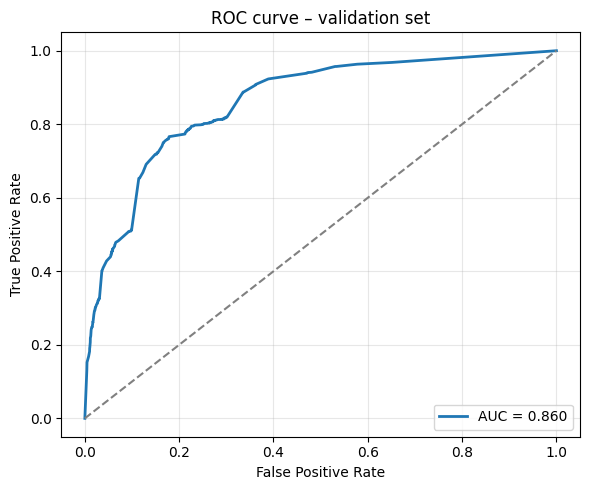

In [3]:

# ---------- 5) METRICS + ROC CURVE ----------
proba_val = final.predict_proba(X_val2)[:, 1]
auc  = roc_auc_score(y_val2, proba_val)
aupr = average_precision_score(y_val2, proba_val)

print(f"Tiles retained : {X_sel.shape[0]:,} / {X.shape[0]:,}")
print(f"AUC-ROC        : {auc:.4f}")
print(f"Average Prec.  : {aupr:.4f}")

# Courbe ROC
fpr, tpr, _ = roc_curve(y_val2, proba_val)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"AUC = {auc:.3f}", linewidth=2)
plt.plot([0,1],[0,1], linestyle='--', color='grey')
plt.title("ROC curve – validation set")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [15]:
import numpy as np
import pandas as pd
import os, datetime, re
from pathlib import Path

# ------------------------------------------------------------------
# 0)  CHEMINS (à adapter si besoin)
# ------------------------------------------------------------------
data_dir          = Path("C:/Users/flobm/PRAMA_2025")
test_features_dir = data_dir / "test_input/test_input/moco_features"
out_dir           = data_dir / "Outputs"
out_dir.mkdir(exist_ok=True, parents=True)

# ------------------------------------------------------------------
# 1)  PARAMÈTRES INFERENCE
# ------------------------------------------------------------------
k_top_tiles = 100
agg_method  = "mean"          # "mean" ou "max"

# ------------------------------------------------------------------
# 2)  TRI “NATURAL SORT” + UTILS
# ------------------------------------------------------------------
def natural_key(path_obj):
    """Clé de tri type '10' > '2', gère aussi des préfixes/suffixes."""
    return [
        int(tok) if tok.isdigit() else tok.lower()
        for tok in re.split(r"(\d+)", path_obj.name)
    ]

def sample_id_from_path(p: Path) -> str:
    """Récupère l'ID sans l'extension (si elle existe)."""
    return p.stem if p.suffix else p.name

# ------------------------------------------------------------------
# 3)  FONCTION PRINCIPALE
# ------------------------------------------------------------------
def predict_test_and_save(
    base_model,
    final_model,
    k=k_top_tiles,
    aggregate=agg_method,
    features_dir=test_features_dir,
    output_dir=out_dir,
    prefix="test_output",
):
    """
    Prédit la proba par lame sur le jeu de test et écrit un CSV
    'Sample ID,Target' trié par ID croissant,
    avec .npy ajouté dans la colonne Sample ID.
    """
    preds = []

    # Liste des fichiers, triés “naturellement”
    files = sorted(
        [p for p in features_dir.iterdir() if p.is_file()],
        key=natural_key,
    )

    for path in files:
        sample_id_raw = sample_id_from_path(path)      # ex. "ID_022"
        sample_id_npy = f"{sample_id_raw}.npy"         # ex. "ID_022.npy"
        mat = np.load(path)[:, 3:]                     # (n_tiles, 2048)

        # ----- Étape A : scores base_model -----
        proba_base = base_model.predict_proba(mat)[:, 1]

        # ----- Étape B : top-k -----
        if k is not None and len(proba_base) > k:
            sel_idx   = np.argsort(-proba_base)[:k]
            feats_sel = mat[sel_idx]
        else:
            feats_sel = mat

        # ----- Étape C : final_model -----
        proba_tiles = final_model.predict_proba(feats_sel)[:, 1]

        # ----- Étape D : agrégation -----
        if aggregate == "mean":
            sample_prob = proba_tiles.mean()
        elif aggregate == "max":
            sample_prob = proba_tiles.max()
        else:
            raise ValueError("aggregate must be 'mean' or 'max'")

        preds.append((sample_id_npy, sample_prob))

    # ------------------------------------------------------------------
    # 4)  EXPORT CSV
    # ------------------------------------------------------------------
    preds.sort(key=lambda x: natural_key(Path(x[0])))          # tri par ID
    timestamp = datetime.datetime.now().strftime("%m_%d-%H_%M")
    out_path  = output_dir / f"{prefix}-{timestamp}.csv"

    pd.DataFrame(preds, columns=["Sample ID", "Target"]).to_csv(out_path, index=False)
    print(f"[✓] Submission sauvegardée dans : {out_path}")

# ------------------------------------------------------------------
# 5)  APPEL (base et final sont tes deux modèles déjà entraînés)
# ------------------------------------------------------------------
predict_test_and_save(base, final)


[✓] Submission sauvegardée dans : C:\Users\flobm\PRAMA_2025\Outputs\test_output-06_22-18_17.csv


# Version 2 : Cross validation et méthodes pour limiter l'over-fitting

In [3]:
import numpy as np
import pandas as pd
import os
import re
import datetime
from pathlib import Path

from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score

import xgboost as xgb



# ------------------------------------------------------------------
# 0)  CHEMINS (garde tes chemins actuels)
# ------------------------------------------------------------------
data_dir          = Path("C:/Users/flobm/PRAMA_2025")
features_dir      = data_dir / "train_input/train_input/moco_features"
labels_path       = data_dir / "train_output.csv"

# ------------------------------------------------------------------
# 1)  CHARGEMENT TUILE-PAR-TUILE + GROUPES
# ------------------------------------------------------------------
labels_df = pd.read_csv(labels_path).set_index("Sample ID")

X_lst, y_lst, g_lst = [], [], []          # features, labels, group-ids

for sid, target in labels_df["Target"].items():
    f = features_dir / f"{sid}"
    if not f.exists():
        print(f"Missing {f}")
        continue
    mat = np.load(f)[:, 3:]               # (n_tiles, 2048)
    n   = mat.shape[0]

    X_lst.append(mat)
    y_lst.append(np.full(n, target))
    g_lst.append(np.repeat(str(sid), n))  # ID complet, pas tronqué

X       = np.vstack(X_lst)
y       = np.concatenate(y_lst)
groups  = np.concatenate(g_lst)           # (N_tiles,)

print("Totales tuiles :", X.shape[0])

# ------------------------------------------------------------------
# 2)  PARAMÈTRES GLOBAUX
# ------------------------------------------------------------------
k_top     = 200                 # top-k tuiles retenues / lame
n_folds   = 5                   # GroupKFold
seed_base = 42

xgb_params = dict(
    n_estimators      = 150,
    max_depth         = 5,
    min_child_weight  = 7,
    subsample         = 0.7,
    colsample_bytree  = 0.7,
    gamma             = 0.3,
    reg_lambda        = 2,      # L2
    booster           = "dart", # dropout among trees
    rate_drop         = 0.1,
    learning_rate     = 0.05,
    eval_metric       = "auc",
    use_label_encoder = False,
    n_jobs            = -1,
)

# ------------------------------------------------------------------
# 3)  FONCTION SELECTION TOP-k  (sur un sous-ensemble)
# ------------------------------------------------------------------
def select_top_k(mat, probs, label, k):
    """Retourne indices des k tuiles 'les plus cohérentes' avec le label."""
    if k is None or len(probs) <= k:
        return np.arange(len(probs))
    score = probs if label == 1 else (1 - probs)
    return np.argsort(-score)[:k]

# ------------------------------------------------------------------
# 4)  TRAIN EN CROSS-VAL 5 FOLDS PAR LAME
# ------------------------------------------------------------------
gkf           = GroupKFold(n_splits=n_folds)
oof_pred      = np.zeros_like(y, dtype=float)
models        = []
fold_aucs     = []

for fold, (tr_idx, val_idx) in enumerate(gkf.split(X, y, groups)):
    print(f"\n── Fold {fold+1}/{n_folds} ───────────────────────────")

    # -------- Stage-1  : modèle brouillon sur toutes les tuiles TRAIN --------
    base = xgb.XGBClassifier(random_state=seed_base + fold,
                             **{k: v for k, v in xgb_params.items()
                                if k not in ("booster", "rate_drop")})  # booster 'gbtree'
    base.fit(X[tr_idx], y[tr_idx])

    # -------- Sélection top-k (TRAIN + VAL séparément) --------
    sel_mask = np.zeros_like(y, dtype=bool)

    for sid in np.unique(groups):
        idx_all = np.where(groups == sid)[0]            # tuiles de cette lame
        probs    = base.predict_proba(X[idx_all])[:, 1]
        label    = y[idx_all[0]]
        top_idx  = idx_all[select_top_k(X[idx_all], probs, label, k_top)]
        sel_mask[top_idx] = True

    # Indices sélectionnés par split
    tr_sel  = sel_mask & np.isin(np.arange(len(y)), tr_idx)
    val_sel = sel_mask & np.isin(np.arange(len(y)), val_idx)

    X_tr, y_tr = X[tr_sel],  y[tr_sel]
    X_val, y_val = X[val_sel], y[val_sel]

    print(f"  → {X_tr.shape[0]:,} tuiles train  | {X_val.shape[0]:,} val")

    # -------- Stage-2  : modèle final régularisé --------
    final = xgb.XGBClassifier(
        scale_pos_weight = (y_tr == 0).sum() / (y_tr == 1).sum(),
        random_state     = seed_base + fold,
        **xgb_params
    )

    # ---------------------------------------------------
    # tentative 1 : version xgboost ≥ 1.3  (early_stopping_rounds dispo)
    # tentative 2 : version 1.0-1.2       (callbacks dispo)
    # fallback    : version ≤ 0.90        (aucun des deux)
    # ---------------------------------------------------
    fitted = False
    try:
        final.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            early_stopping_rounds=40,
            verbose=False,
        )
        fitted = True
    except TypeError:
        pass                        # on retente plus bas

    if not fitted:
        try:
            from xgboost.callback import EarlyStopping       # peut ne pas exister
            final.fit(
                X_tr, y_tr,
                eval_set=[(X_val, y_val)],
                verbose=False,
                callbacks=[EarlyStopping(rounds=40, save_best=True)],
            )
            fitted = True
        except (TypeError, ImportError):
            pass

    if not fitted:                  # dernier recours : pas d'early-stop
        final.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            verbose=False,
        )
    # -------- Prédictions fold + métrique --------
    val_pred           = final.predict_proba(X_val)[:, 1]
    oof_pred[val_sel]  = val_pred
    auc_fold           = roc_auc_score(y_val, val_pred)
    fold_aucs.append(auc_fold)
    print(f"  AUC fold = {auc_fold:.4f}")

    models.append(final)

# ------------------------------------------------------------------
# 5)  METRICS CV
# ------------------------------------------------------------------
cv_auc  = roc_auc_score(y[np.flatnonzero(sel_mask)], oof_pred[sel_mask])
print("\n========== RÉSUMÉ CV ==========")
print(f"AUC (OOF, top-k) = {cv_auc:.4f}")
print(f"Moyenne folds    = {np.mean(fold_aucs):.4f} ± {np.std(fold_aucs):.4f}")

# À ce stade :
#   • `models` contient 5 modèles (un par fold) pour l’ENSEMBLE final.
#   • Pour l’inference test : faire la moyenne des proba des 5 modèles.


Totales tuiles : 344000

── Fold 1/5 ───────────────────────────


c:\Users\flobm\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:47:45] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  → 55,000 tuiles train  | 13,800 val


c:\Users\flobm\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [21:51:07] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  AUC fold = 0.9757

── Fold 2/5 ───────────────────────────


c:\Users\flobm\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:07:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  → 55,000 tuiles train  | 13,800 val


c:\Users\flobm\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:10:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  AUC fold = 0.9609

── Fold 3/5 ───────────────────────────


c:\Users\flobm\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:27:27] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  → 55,000 tuiles train  | 13,800 val


c:\Users\flobm\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:30:54] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  AUC fold = 0.9572

── Fold 4/5 ───────────────────────────


c:\Users\flobm\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:47:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  → 55,000 tuiles train  | 13,800 val


c:\Users\flobm\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:50:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  AUC fold = 0.9675

── Fold 5/5 ───────────────────────────


c:\Users\flobm\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:07:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  → 55,200 tuiles train  | 13,600 val


c:\Users\flobm\miniconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [23:10:51] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  AUC fold = 0.9755

========== RÉSUMÉ CV ==========
AUC (OOF, top-k) = 0.6602
Moyenne folds    = 0.9674 ± 0.0075


In [5]:
import numpy as np
import pandas as pd
import os, datetime, re
from pathlib import Path

# ------------------------------------------------------------------
# 0)  CHEMINS (à adapter si besoin)
# ------------------------------------------------------------------
data_dir          = Path("C:/Users/flobm/PRAMA_2025")
test_features_dir = data_dir / "test_input/test_input/moco_features"
out_dir           = data_dir / "Outputs"
out_dir.mkdir(exist_ok=True, parents=True)

# ------------------------------------------------------------------
# 1)  PARAMÈTRES INFERENCE
# ------------------------------------------------------------------
k_top_tiles = 200
agg_method  = "mean"          # "mean" ou "max"

# ------------------------------------------------------------------
# 2)  TRI “NATURAL SORT” + UTILS
# ------------------------------------------------------------------
def natural_key(path_obj):
    """Clé de tri type '10' > '2', gère aussi des préfixes/suffixes."""
    return [
        int(tok) if tok.isdigit() else tok.lower()
        for tok in re.split(r"(\d+)", path_obj.name)
    ]

def sample_id_from_path(p: Path) -> str:
    """Récupère l'ID sans l'extension (si elle existe)."""
    return p.stem if p.suffix else p.name
# ------------------------------------------------------------------
#  FONCTION PRINCIPALE  –  ENSEMBLE MOYENNÉ
# ------------------------------------------------------------------
def predict_test_and_save(
    base_model,                # XGB entraîné sur toutes les tuiles (stage 1)
    final_models,              # LISTE de modèles (stage 2 : 5 folds, par ex.)
    k=200,                     # top-k tuiles conservées
    aggregate="mean",          # "mean" ou "max" tuile→lame
    features_dir=test_features_dir,
    output_dir=out_dir,
    prefix="test_output",
):
    """
    Produit le CSV 'Sample ID,Target' avec probas moyennées sur plusieurs modèles.
    """
    preds = []

    files = sorted(
        [p for p in features_dir.iterdir() if p.is_file()],
        key=natural_key,
    )

    for path in files:
        sid_raw = sample_id_from_path(path)      # ex. "ID_022"
        sid_csv = f"{sid_raw}.npy"               # ex. "ID_022.npy"
        mat     = np.load(path)[:, 3:]           # (n_tiles, 2048)

        # --------- Étape A : scores base_model et top-k ---------
        proba_base = base_model.predict_proba(mat)[:, 1]
        if k is not None and len(proba_base) > k:
            idx_keep = np.argsort(-proba_base)[:k]
            feats    = mat[idx_keep]
        else:
            feats    = mat

        # --------- Étape B : prédiction par CHAQUE modèle ---------
        tile_preds = np.column_stack(
            [m.predict_proba(feats)[:, 1] for m in final_models]
        )                                           # shape (n_tiles, n_models)

        # Moyenne des modèles pour chaque tuile
        tile_mean = tile_preds.mean(axis=1)         # shape (n_tiles,)

        # --------- Étape C : agrégation tuile → lame ---------
        sample_prob = (
            tile_mean.mean() if aggregate == "mean" else tile_mean.max()
        )

        preds.append((sid_csv, sample_prob))

    # ------------------------------------------------------------------
    #  EXPORT CSV
    # ------------------------------------------------------------------
    preds.sort(key=lambda x: natural_key(Path(x[0])))
    ts       = datetime.datetime.now().strftime("%m_%d-%H_%M")
    out_path = output_dir / f"{prefix}-{ts}.csv"

    pd.DataFrame(preds, columns=["Sample ID", "Target"]).to_csv(out_path, index=False)
    print(f"[✓] Submission sauvegardée dans : {out_path}")

# ------------------------------------------------------------------
#  APPEL
# ------------------------------------------------------------------
#   • 'base'  : modèle entraîné stage 1 sur toutes les tuiles
#   • 'models': liste contenant les 5 modèles “final” (stage 2, un par fold)
predict_test_and_save(base, models)


[✓] Submission sauvegardée dans : C:\Users\flobm\PRAMA_2025\Outputs\test_output-06_18-23_36.csv
